# Graph Visualizations

In [ ]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
print(parent)
%matplotlib widget

## Data

## Prediction

In [ ]:
directory = os.path.join("data", "raw", "unzipped", "BACH_TEST", "ICIAR2018_BACH_Challenge_TestDataset", "Photos")
file_name = "test0.tif"

img_loc = os.path.join(parent,directory, file_name)

In [ ]:

import os
from src.model.architectures.graph_construction.hover_net import HoVerNet
from src.model.architectures.cancer_prediction.cell_unet_ae import UNET_AE
from src.model.architectures.cancer_prediction.pred_gnn import PredGNN
from PIL import Image
from torchvision.transforms import ToTensor
from src.transforms.graph_construction.hovernet_post_processing import instance_mask_prediction_hovernet, cut_img_from_tile
from src.transforms.graph_construction.graph_extractor import extract_graph, cell_to_voting_graph
from torch_geometric.transforms import Compose, KNNGraph, RandomTranslate, Distance
import torch
from torch_geometric.loader.dataloader import DataLoader
import matplotlib.backends.backend_pdf
from src.utilities.img_utilities import tensor_to_numpy
import matplotlib.pyplot as plt
from src.transforms.graph_construction.percolation import hollow
from numpy.ma import masked_where
import numpy as np
import torch
from torch import Tensor

with torch.no_grad():
    graph_trans = Compose([KNNGraph(6),  Distance(norm=False, cat=False)])

    gnn_voter_args = {"LAYERS": 10, "WIDTH": 8, "GLOBAL_POOL": "MEAN", "RADIUS_FUNCTION": "INVSQUARE", "POOL_RATIO": 1}

    hover_net_loc=os.path.join(parent,"model", "HoVerNet.ckpt")
    cell_predictor_loc=os.path.join(parent,"model", "CELL_PREDICTOR.ckpt")
    gnn_voter_loc=os.path.join(parent,"model", "GNN_VOTER.ckpt")


    hover_net = HoVerNet.load_from_checkpoint(hover_net_loc).eval().cpu()
    cell_predictor = UNET_AE.load_from_checkpoint(cell_predictor_loc).eval().cpu()
    def cell_predict(X): return cell_predictor.forward_pred(X)
    gnn_voter = PredGNN.load_from_checkpoint(gnn_voter_loc, **gnn_voter_args).eval().cpu()

    # Load the image
    image = ToTensor()(Image.open(img_loc))

    # Create Instance Mask for cells
    instance_mask = instance_mask_prediction_hovernet(hover_net, image).cpu().detach()
    image_cropped = cut_img_from_tile(image, 128)

    del hover_net
    del image
    torch.cuda.empty_cache()


#del gnn_voter



In [ ]:
# Generate Cell Graph
cell_graph = extract_graph(image_cropped, instance_mask)
cell_graph.x.requires_grad_(True)
# Generate Voting Graph

voting_graph = cell_to_voting_graph(cell_graph, cell_predict)
voting_graph = graph_trans(voting_graph)
voting_graph.x.requires_grad_(True)
voting_graph.x.retain_grad()
#del cell_predictor

# Make Final Prediction

prediction = gnn_voter(voting_graph.x, voting_graph.edge_index, voting_graph.edge_attr,
                        torch.zeros(voting_graph.x.shape[0]).long()).squeeze()
prediction[prediction.argmax()].backward()


## Explanations

In [ ]:

print(prediction)
print(cell_graph.x.grad)
print(voting_graph.x.grad)

In [222]:
import torch
import matplotlib.pyplot as plt
from src.vizualizations.tensor_viz import plot_tensor_histogram

def plot_graph_crop_on_image(X,pos,image):
    img = torch.zeros_like(image)
    for i,(c,r) in enumerate(pos):
        r,c = r.int(),c.int()
        img[:,r-32:r+32,c-32:c+32] += X[i]
        #if i ==10:
         #   break
    #img = img.max(dim=0).values*20

    #plot_tensor_histogram(img.flatten(1).clip(1e-17,1e-7).log(), bins=10000)
    #plt.show()
    print(img.mean())
    img = (image.sum(dim=-0)*img.mean(dim=0)).detach().cpu()
    plt.figure(figsize=(10,10))
    plt.imshow(tensor_to_numpy(img),cmap="winter")
    plt.show()
    
    
def plot_crop(crop):
    plt.figure(figsize=(10,10))
    plt.imshow(tensor_to_numpy(crop),cmap="cool")
    plt.show()

tensor(0.0575)


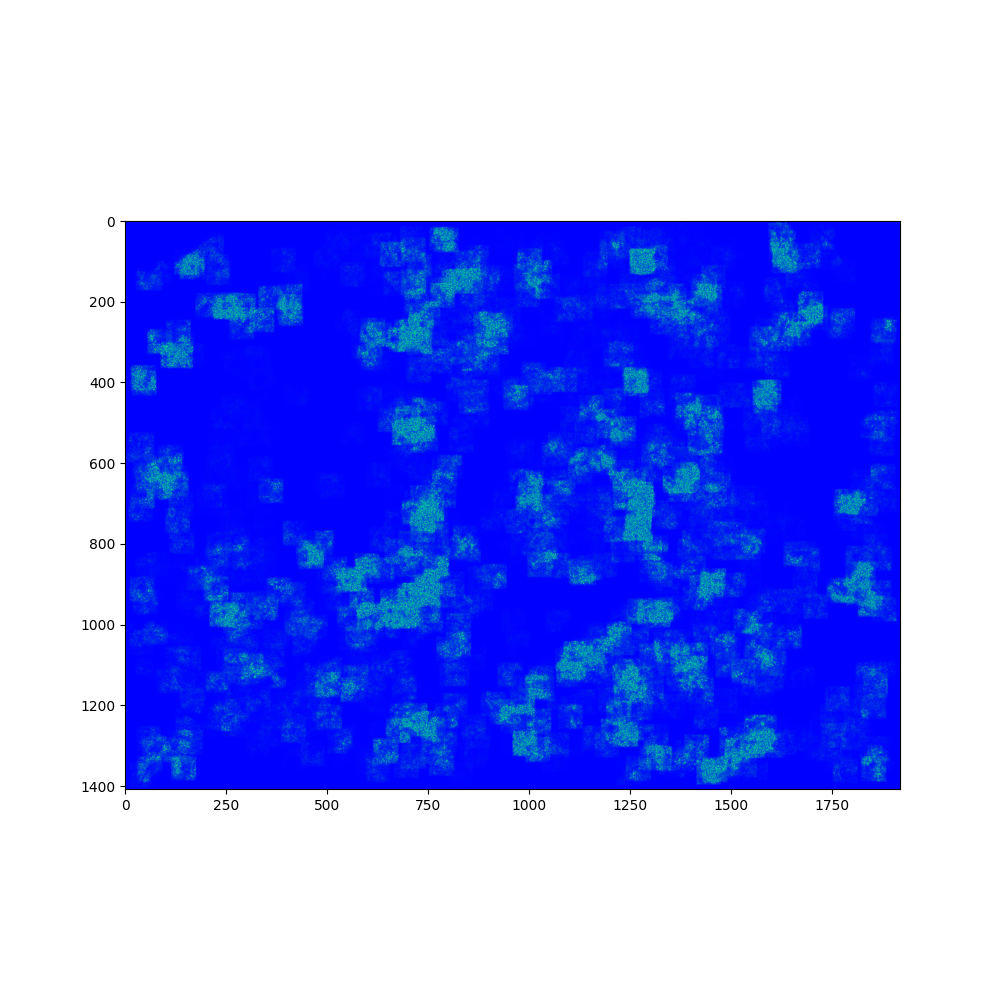

tensor(0.0117)


In [223]:
grad = cell_graph.x.grad.clone().unflatten(1,(3,64,64)).detach()
X = cell_graph.x.clone().unflatten(1,(3,64,64)).detach()
i=11
#plot_tensor_histogram((grad[i]*X[i]).sum(dim=0).flatten(),bins=1000)
#print(grad[i].sum(dim=0).flatten().sum())
plot_graph_crop_on_image(grad.abs()*10000,cell_graph.pos,image_cropped)
print((X[i]*grad[i].abs()).sum())
#plot_crop(X[i])
#plot_crop((X[i]).sum(dim=0)*grad[i].abs().sum(dim=0)*10000)

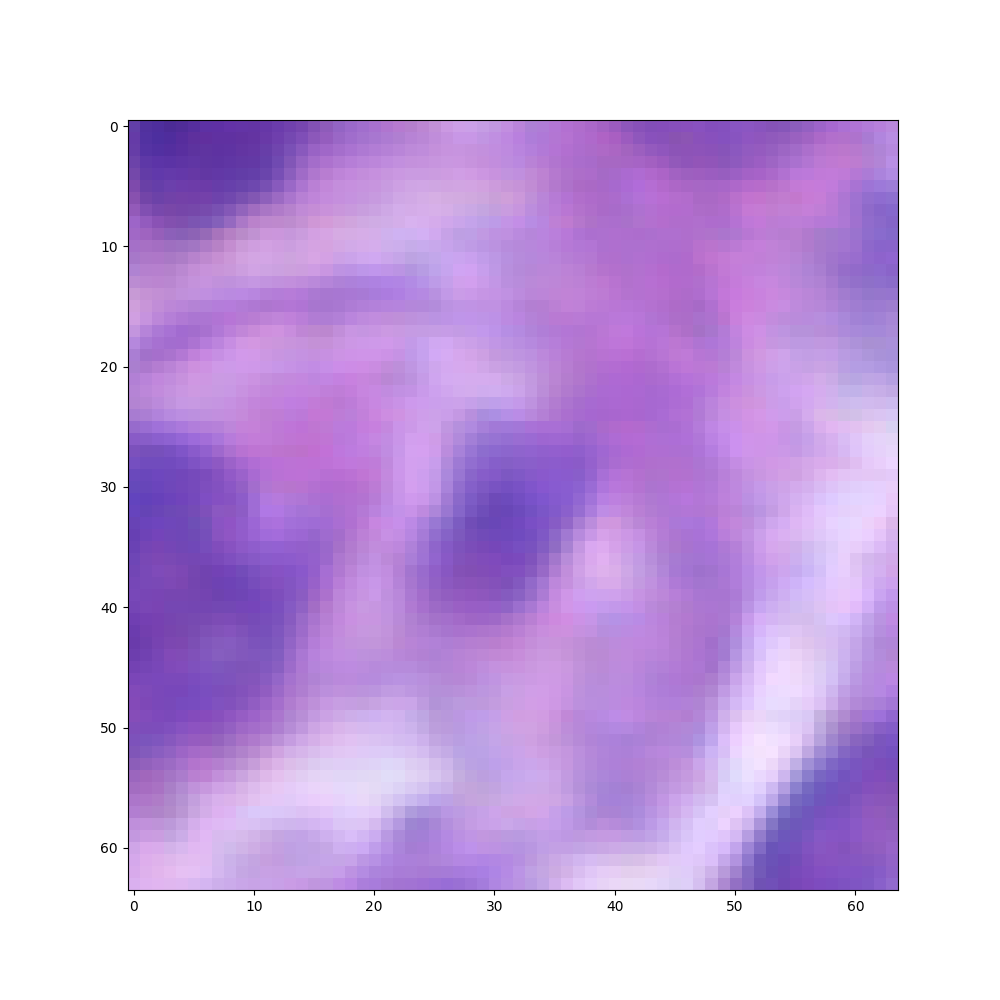

In [194]:
plot_crop((X[i]))